<a href="https://colab.research.google.com/github/bishan5/A-Predictive-Traffic-Flow-Modelling-for-ITS/blob/main/Univariate_Time_Series_Forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Import Necessary Libraries**

In [1]:
# Basic data manipulation and numerical operations
import numpy as np
import pandas as pd

# Machine learning tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Deep learning imports - TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Google Colab specific
from google.colab import files
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
FILE_PATH = '/content/drive/MyDrive/Clean_Metro_Interstate_Traffic_Volume.csv'
data = pd.read_csv(FILE_PATH)

In [4]:
data

,Timestamp,Traffic_volume,Holiday,Temp,Rain_1h,Snow_1h,Clouds_all,Weather_main,weather_description
0,01/07/2015 00:00,737,NaN,289.20,0.0,0.0,1.0,Clear,sky is clear
1,01/07/2015 01:00,444,NaN,289.40,0.0,0.0,1.0,Clear,sky is clear
2,01/07/2015 02:00,347,NaN,289.19,0.0,0.0,1.0,Clear,sky is clear
3,01/07/2015 03:00,356,NaN,288.74,0.3,0.0,1.0,Rain,light rain
4,01/07/2015 04:00,936,NaN,288.07,0.0,0.0,1.0,Clear,sky is clear
...,...,...,...,...,...,...,...,...,...
28507,30/09/2018 19:00,3543,NaN,283.45,0.0,0.0,75.0,Clouds,broken clouds
28508,30/09/2018 20:00,2781,NaN,282.76,0.0,0.0,90.0,Clouds,overcast clouds
28509,30/09/2018 21:00,2159,NaN,282.73,0.0,0.0,90.0,Thunderstorm,proximity thunderstorm
28510,30/09/2018 22:00,1450,NaN,282.09,0.0,0.0,90.0,Clouds,overcast clouds


<ipython-input-5-1800c1f1d88e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Day_Type'] = recent_data['Timestamp'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
<ipython-input-5-1800c1f1d88e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Day_Label'] = recent_data['Timestamp'].dt.strftime('%a %b %d %H:%M')  # Format: 'Day Month Date Hour:Minute'


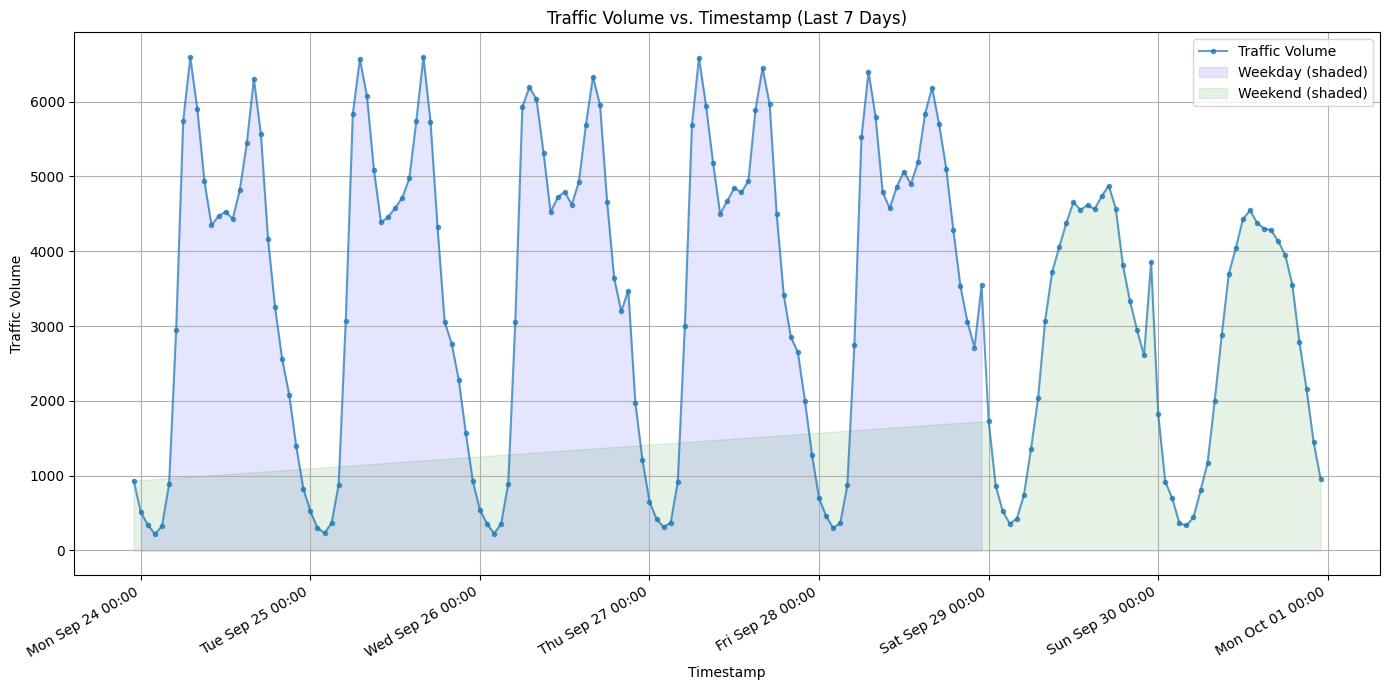

In [5]:
# Convert the 'Timestamp' column to datetime objects
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d/%m/%Y %H:%M')

# Filter data for the last 7 days
last_7_days = data['Timestamp'].max() - pd.Timedelta(days=7)
recent_data = data[data['Timestamp'] >= last_7_days]

# Identify weekdays and weekends
recent_data['Day_Type'] = recent_data['Timestamp'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Add the day of the week to the x-axis labels
recent_data['Day_Label'] = recent_data['Timestamp'].dt.strftime('%a %b %d %H:%M')  # Format: 'Day Month Date Hour:Minute'

# Create the plot
plt.figure(figsize=(14, 7))

# Plot traffic volume
plt.plot(recent_data['Timestamp'], recent_data['Traffic_volume'], label='Traffic Volume', alpha=0.7, linestyle='-', marker='o', markersize=3)

# Color-code weekdays and weekends
for day_type in ['Weekday', 'Weekend']:
    filtered_data = recent_data[recent_data['Day_Type'] == day_type]
    plt.fill_between(
        filtered_data['Timestamp'],
        0,
        filtered_data['Traffic_volume'],
        alpha=0.1,
        label=f'{day_type} (shaded)',
        color='blue' if day_type == 'Weekday' else 'green'
    )

# Format x-axis to show day labels
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %b %d %H:%M'))  # Format includes day

# Enhance the plot
plt.xlabel('Timestamp')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume vs. Timestamp (Last 7 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

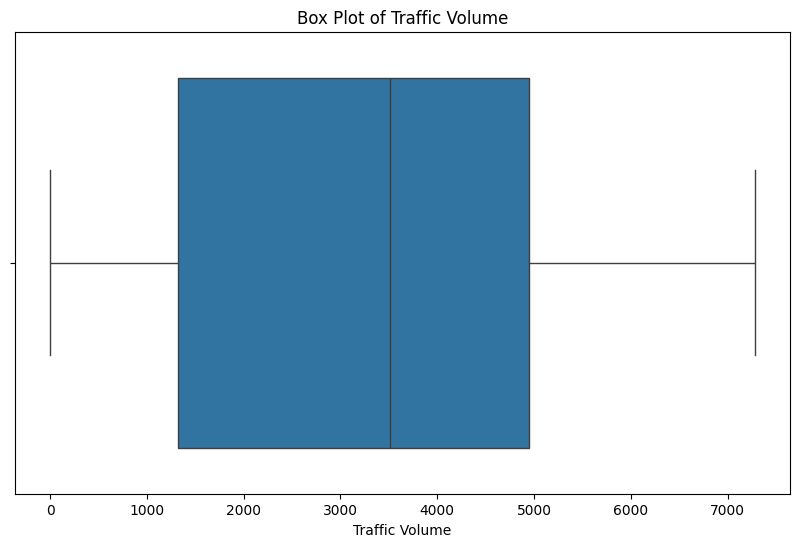

In [6]:
# create box plot

plt.figure(figsize=(10, 6))
sns.boxplot(x='Traffic_volume', data=data)
plt.title('Box Plot of Traffic Volume')
plt.xlabel('Traffic Volume')
plt.show()

In [7]:
# Calculate the first quartile (Q1) and third quartile (Q3) of the traffic volume
Q1 = data['Traffic_volume'].quantile(0.25)
Q3 = data['Traffic_volume'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data = data[~((data['Traffic_volume'] < lower_bound) | (data['Traffic_volume'] > upper_bound))]

In [8]:
# Convert 'Holiday' column values: NaN to 0, others to 1
data['Holiday'] = data['Holiday'].apply(lambda x: 0 if pd.isna(x) else 1)

In [9]:
# Convert 'Timestamp' to datetime and extract features
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d/%m/%Y %H:%M')
data['Hour'] = data['Timestamp'].dt.hour
data['Day'] = data['Timestamp'].dt.day
data['Weekday'] = data['Timestamp'].dt.weekday
data['Is_night'] = data['Hour'].isin([22,23,0,1,2,3,4,5])
data['Month'] = data['Timestamp'].dt.month
data['Is_weekend'] = data['Weekday'].isin([5, 6])
data['Year'] = data['Timestamp'].dt.year

In [10]:
data.head()

,Timestamp,Traffic_volume,Holiday,Temp,Rain_1h,Snow_1h,Clouds_all,Weather_main,weather_description,Hour,Day,Weekday,Is_night,Month,Is_weekend,Year
0,2015-07-01 00:00:00,737,0,289.20,0.0,0.0,1.0,Clear,sky is clear,0,1,2,True,7,False,2015
1,2015-07-01 01:00:00,444,0,289.40,0.0,0.0,1.0,Clear,sky is clear,1,1,2,True,7,False,2015
2,2015-07-01 02:00:00,347,0,289.19,0.0,0.0,1.0,Clear,sky is clear,2,1,2,True,7,False,2015
3,2015-07-01 03:00:00,356,0,288.74,0.3,0.0,1.0,Rain,light rain,3,1,2,True,7,False,2015
4,2015-07-01 04:00:00,936,0,288.07,0.0,0.0,1.0,Clear,sky is clear,4,1,2,True,7,False,2015


In [11]:
# 1. Encode 'Year' using Ordinal Encoding (2015-2018 → 0-3)
data['Year'] = data['Year'] - 2015

# 2. Convert Boolean features to integers (Binary Encoding)
data['Is_weekend'] = data['Is_weekend'].astype(int)
data['Is_night'] = data['Is_night'].astype(int)
data['Holiday'] = data['Holiday'].astype(int)

# 3. Apply Label Encoding for 'Weather_main'
label_encoder = LabelEncoder()
data['Weather_main'] = label_encoder.fit_transform(data['Weather_main'])

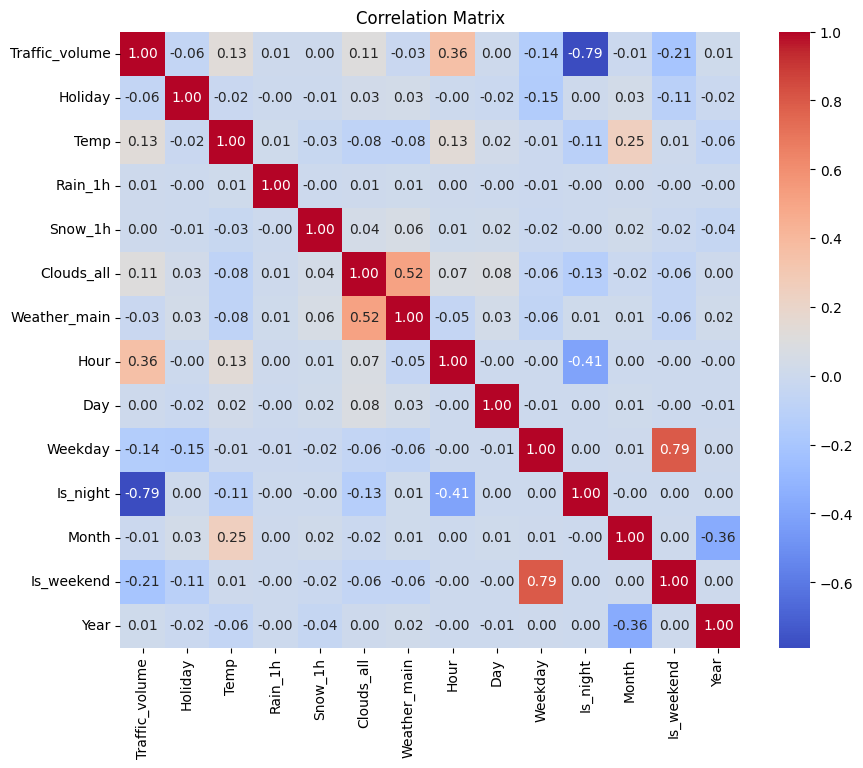

In [12]:
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=['number'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [13]:
# Scale the target variable
scaler = MinMaxScaler()
data['Traffic_volume'] = scaler.fit_transform(data[['Traffic_volume']])

In [14]:
# Define a function to create sequences for multi-step forecasting
def create_sequences(data, look_back, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon + 1):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back:i + look_back + forecast_horizon])
    return np.array(X), np.array(y)

# Parameters for the sequence
look_back = 24  # Use the past 24 hours for prediction
forecast_horizon = 3  # Predict the next 3 hours

# Prepare the data for multi-step forecasting
traffic_volume = data['Traffic_volume'].values
X, y = create_sequences(traffic_volume, look_back, forecast_horizon)

# Split into training and testing datasets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [15]:
# Build the LSTM Model
# Parameter choosen based on keras tuner iteration in above code
def build_lstm_model(input_shape):
    model = Sequential()

    # First LSTM layer with dropout
    model.add(LSTM(224, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.4))

    # Second LSTM layer with dropout
    model.add(LSTM(160, return_sequences=False))
    model.add(Dropout(0.4))

    # Dense layer
    model.add(Dense(48, activation='relu'))

    # Output layer for predicting the next 3 hours
    model.add(Dense(3))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

# Build and compile the model
model = build_lstm_model(input_shape=(look_back, X_train.shape[2]))

# Summary of the model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 224)             │         202,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 224)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 160)                 │         246,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 48)                  │           7,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 456,771 (1.74 MB)

 Trainable params: 456,771 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0508 - mae: 0.1664 - val_loss: 0.0128 - val_mae: 0.0784 - learning_rate: 0.0010
Epoch 2/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0144 - mae: 0.0868 - val_loss: 0.0080 - val_mae: 0.0634 - learning_rate: 0.0010
Epoch 3/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0099 - mae: 0.0714 - val_loss: 0.0070 - val_mae: 0.0584 - learning_rate: 0.0010
Epoch 4/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0081 - mae: 0.0637 - val_loss: 0.0056 - val_mae: 0.0539 - learning_rate: 0.0010
Epoch 5/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0069 - mae: 0.0587 - val_loss: 0.0049 - val_mae: 0.0467 - learning_rate: 0.0010
Epoch 6/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0064 - mae: 0.0552 - val_loss: 0.0056 - val_mae: 0.0535 - learning_rate: 0.0010
Epoch 7/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0058 - mae: 0.0531 - val_loss: 0.0046 - val_mae: 0.0492 - learning_rate:

In [17]:
# Predictions for train and test sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [18]:
# Reshape predictions and targets to 2D for inverse scaling
train_predict_reshaped = train_predict.reshape(-1, 3)  # Reshape to (number of samples, 3)
test_predict_reshaped = test_predict.reshape(-1, 3)    # Reshape to (number of samples, 3)
y_train_reshaped = y_train.reshape(-1, 3)            # Reshape to (number of samples, 3)
y_test_reshaped = y_test.reshape(-1, 3)              # Reshape to (number of samples, 3)

In [19]:
# Reverse scaling to get actual values
train_predict_rescaled = scaler.inverse_transform(train_predict_reshaped)
test_predict_rescaled = scaler.inverse_transform(test_predict_reshaped)

y_train_rescaled = scaler.inverse_transform(y_train_reshaped)
y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

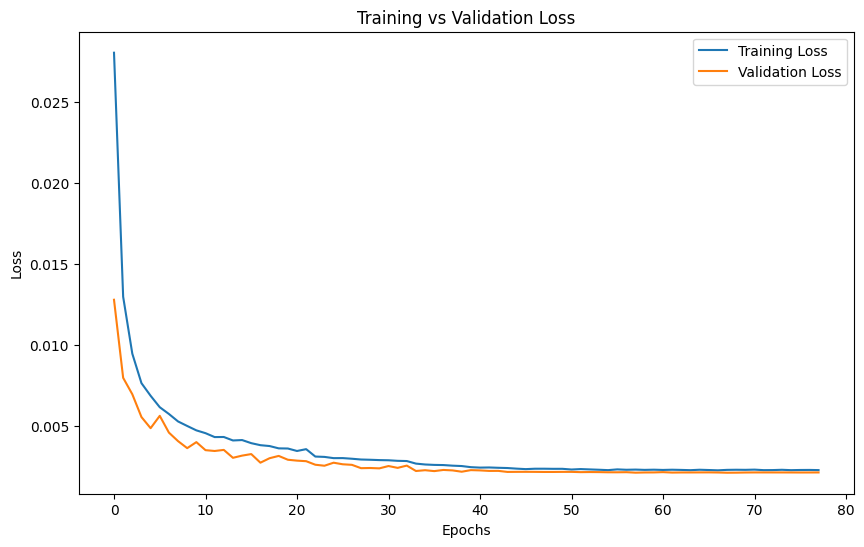

In [20]:
# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [21]:
# Define horizons for evaluation
horizons = range(1, 4)  # From 1-hour to 3-hour forecasts

# Initialize metrics dictionary
metrics = {
    "Training": {},
    "Testing": {}
}

# Loop through each forecast horizon
for i in horizons:
    # Training metrics for i-hour forecast
    train_mse = mean_squared_error(y_train_rescaled[:, i - 1], train_predict_rescaled[:, i - 1])
    train_mae = mean_absolute_error(y_train_rescaled[:, i - 1], train_predict_rescaled[:, i - 1])
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train_rescaled[:, i - 1], train_predict_rescaled[:, i - 1])

    # Testing metrics for i-hour forecast
    test_mse = mean_squared_error(y_test_rescaled[:, i - 1], test_predict_rescaled[:, i - 1])
    test_mae = mean_absolute_error(y_test_rescaled[:, i - 1], test_predict_rescaled[:, i - 1])
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test_rescaled[:, i - 1], test_predict_rescaled[:, i - 1])

    # Store metrics in the dictionary
    metrics["Training"][f"{i}-Hour"] = {"MSE": train_mse, "MAE": train_mae, "RMSE": train_rmse, "R2": train_r2}
    metrics["Testing"][f"{i}-Hour"] = {"MSE": test_mse, "MAE": test_mae, "RMSE": test_rmse, "R2": test_r2}

# Print the metrics in a formatted way
for dataset, forecast_metrics in metrics.items():
    print(f"\n{dataset} Evaluation Metrics:")
    for forecast, values in forecast_metrics.items():
        print(f"  {forecast} Forecast:")
        for metric, score in values.items():
            print(f"    {metric}: {score:.4f}")



Training Evaluation Metrics:
  1-Hour Forecast:
    MSE: 70617.2817
    MAE: 179.1889
    RMSE: 265.7391
    R2: 0.9815
  2-Hour Forecast:
    MSE: 111473.9414
    MAE: 221.9387
    RMSE: 333.8771
    R2: 0.9708
  3-Hour Forecast:
    MSE: 137822.5051
    MAE: 244.3035
    RMSE: 371.2445
    R2: 0.9639

Testing Evaluation Metrics:
  1-Hour Forecast:
    MSE: 56554.1601
    MAE: 159.1164
    RMSE: 237.8112
    R2: 0.9857
  2-Hour Forecast:
    MSE: 87501.7574
    MAE: 194.5026
    RMSE: 295.8070
    R2: 0.9778
  3-Hour Forecast:
    MSE: 111463.3892
    MAE: 212.3966
    RMSE: 333.8613
    R2: 0.9718


Latest available date: 2018-09-30
Enter a date (YYYY-MM-DD): 2018-07-27


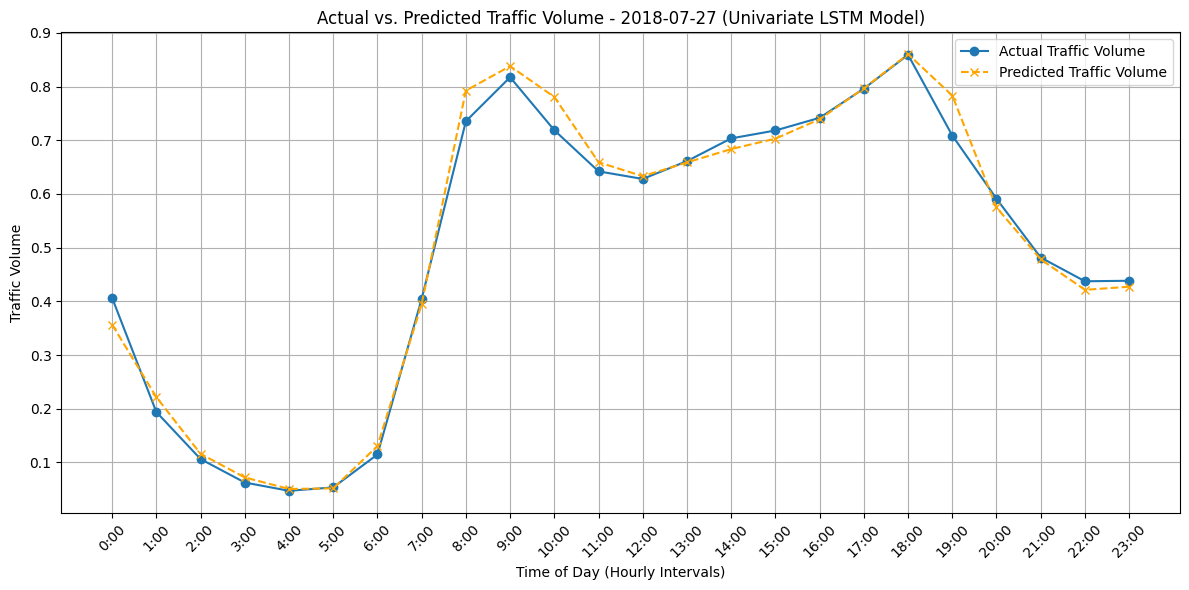

In [27]:
# Allow user to enter a date (YYYY-MM-DD)
latest_date = data['Timestamp'].max().date()
print(f"Latest available date: {latest_date}")
selected_date = input("Enter a date (YYYY-MM-DD): ")

try:
    selected_date = pd.to_datetime(selected_date).date()

    # Filter data for the selected date
    filtered_indices = [
        i for i, timestamp in enumerate(data['Timestamp'][-len(y_test_rescaled):])
        if timestamp.date() == selected_date
    ]

    if not filtered_indices:
        print(f"No data available for the selected date: {selected_date}.")
    else:
        # Select the first occurrence of the date
        day_index = filtered_indices[0]

        # Define 24-hour window
        start_index = day_index
        end_index = min(day_index + 24, len(y_test_rescaled))

        # Extract actual and predicted traffic data
        actual_traffic = y_test_rescaled[start_index:end_index, 0]
        predicted_traffic = test_predict_rescaled[start_index:end_index, 0]

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(actual_traffic)), actual_traffic, label='Actual Traffic Volume', marker='o')
        plt.plot(range(len(predicted_traffic)), predicted_traffic, label='Predicted Traffic Volume', marker='x', linestyle='dashed', color='orange')
        plt.xlabel('Time of Day (Hourly Intervals)')
        plt.ylabel('Traffic Volume')
        plt.title(f'Actual vs. Predicted Traffic Volume - {selected_date} (Univariate LSTM Model)')
        plt.legend()
        plt.grid(True)
        plt.xticks(range(len(actual_traffic)), labels=[f"{h}:00" for h in range(len(actual_traffic))], rotation=45)
        plt.tight_layout()
        plt.show()

except ValueError:
    print("Invalid date format! Please enter a date in YYYY-MM-DD format.")
